## Section 0 - Helper Functions

In [53]:
import matplotlib.pyplot as plt

def zip_to_borough(z):
    z = str(z).zfill(5)  # ensure 5 digit string
    
    if z.startswith(("100", "101", "102")):
        return "Manhattan"
    elif z.startswith("104"):
        return "Bronx"
    elif z.startswith("112"):
        return "Brooklyn"
    elif z.startswith(("110", "111", "113", "114", "116")):
        return "Queens"
    elif z.startswith("103"):
        return "Staten Island"
    else:
        return None  
    
#histogram helper funciton
def plot_hist(data,title,bins=30):
    plt.figure(figsize=(8,4))
    plt.hist(data.dropna(),bins=bins,edgecolor="black")
    plt.title(title)
    plt.xlabel(title)
    plt.ylabel("Frequency")
    plt.show()


#scatterplots 



## SECTION 1 - Import Data

### 1.1 Hospital Data



In [54]:
import pandas as pd

url = "https://data.cityofnewyork.us/resource/2nwg-uqyg.csv"

df = pd.read_csv(url, parse_dates=["date"])     # import, convert to datetime

#clean zips
df["mod_zcta"] = df["mod_zcta"].astype(str).str[:5] 

# aggregate by borough
df["borough"] = df["mod_zcta"].apply(zip_to_borough)

# clean invalid or missing borough rows
df = df[df["borough"].notna()].copy()

# daily borough totals
df_borough_daily = (
    df.groupby(["date", "borough"])     #condense rows by borough and date
      .agg({
          "total_ed_visits": "sum",
          "ili_pne_visits": "sum",
          "ili_pne_admissions": "sum"
      })
      .reset_index()
      .sort_values(["borough", "date"])
)

#city wide
df_city_daily = (
    df_borough_daily.groupby("date")[["total_ed_visits", "ili_pne_visits", "ili_pne_admissions"]]
                     .sum()
                     .reset_index()
)


### 1.2 Weather Data

In [55]:
from meteostat import Daily, Stations
from datetime import datetime
import pandas as pd

# indetify Central Park weather station
stations = Stations()
stations = stations.nearby(40.7812, -73.9665) 
station = stations.fetch(1)

#station id
station_id = station.index[0]

# set range to match ED data
start = df["date"].min()
end = df["date"].max()


# daily weather date
df_weather_daily = Daily(station_id, start, end).fetch().reset_index()

# rename date 
df_weather_daily = df_weather_daily.rename(columns={"time": "date"})


### 1.5 Calendar Data

In [56]:
import pandas as pd
import holidays

start_date = df["date"].min()
end_date = df["date"].max()

# calendar dataframe

calendar = pd.DataFrame({
    "date": pd.date_range(start=start_date, end=end_date, freq="D")
})


#day of the week
calendar["day_of_week"] = calendar["date"].dt.day_name()
calendar["weekday_num"] = calendar["date"].dt.weekday #monday ==0 
calendar["is_weekend"] = calendar["weekday_num"].isin([5,6]).astype(int)

#month, year, week number

calendar["month"] = calendar["date"].dt.month
calendar["year"] = calendar["date"].dt.year
calendar["week_of_year"] = calendar["date"].dt.isocalendar().week.astype(int)

#add seasons
def get_season(month):
    if month in[12,1,2]:
        return "Winter"
    if month in[3,4,5]:
        return "Spring"
    if month in[6,7,8]:
        return "Summer"
    if month in[9,10,11]:
        return "Fall"
    
calendar["season"] = calendar["month"].apply(get_season)

#add holidays
us_holidays = holidays.US()
calendar["is_holiday"] = calendar["date"].isin(us_holidays).astype(int)

print(calendar.head())
print(calendar.tail())
print(calendar.columns)

        date day_of_week  weekday_num  is_weekend  month  year  week_of_year  \
0 2020-03-01      Sunday            6           1      3  2020             9   
1 2020-03-02      Monday            0           0      3  2020            10   
2 2020-03-03     Tuesday            1           0      3  2020            10   
3 2020-03-04   Wednesday            2           0      3  2020            10   
4 2020-03-05    Thursday            3           0      3  2020            10   

   season  is_holiday  
0  Spring           0  
1  Spring           0  
2  Spring           0  
3  Spring           0  
4  Spring           0  
           date day_of_week  weekday_num  is_weekend  month  year  \
1003 2022-11-29     Tuesday            1           0     11  2022   
1004 2022-11-30   Wednesday            2           0     11  2022   
1005 2022-12-01    Thursday            3           0     12  2022   
1006 2022-12-02      Friday            4           0     12  2022   
1007 2022-12-03    Saturday   

# Section 2 - Cleaning + Merging Data

### 2.1 Clean Data

In [57]:
import pandas as pd

# ------------------
# CLEAN ED DATASET
# ------------------
df_borough_daily = df_borough_daily.copy()

# make lowercase columns
df_borough_daily.columns = df_borough_daily.columns.str.lower()

# date = datetime
df_borough_daily["date"] = pd.to_datetime(df_borough_daily["date"])

# Sort by borough/date
df_borough_daily = df_borough_daily.sort_values(["borough", "date"])


# ------------------
# CLEAN WEATHER DATASET
# ------------------

df_weather_daily = df_weather_daily.copy()

# Lowercase column names
df_weather_daily.columns = df_weather_daily.columns.str.lower()

#date = datetime
df_weather_daily["date"] = pd.to_datetime(df_weather_daily["date"])

#srt by date
df_weather_daily = df_weather_daily.sort_values("date")

# ------------------
# CLEAN calendar DATASET
# ------------------

calendar = calendar.copy()

calendar.columns = calendar.columns.str.lower()

calendar["date"] = pd.to_datetime(calendar["date"])

calendar = calendar.sort_values("date")


# -- ---------
# Weather for all 5 boroughs
#-------------------

boroughs = df_borough_daily["borough"].unique()

df_weather_borough = (
    df_weather_daily.assign(key=1)
    .merge(pd.DataFrame({"borough": boroughs, "key": 1}), on="key")
    .drop(columns=["key"])
)

df_weather_borough = df_weather_borough.sort_values(["borough", "date"]).reset_index(drop=True)


### 2.2 Merge Data

In [58]:
#------------------
# ED + Weather
#------------------
df_final = df_borough_daily.merge(
    df_weather_borough,
    on=["date","borough"],
    how="left"
)

#------------------
# Final + Calendar
#------------------

df_final = df_final.merge(
    calendar,
    on="date",
    how="left"
)

df_final = df_final.sort_values(["borough", "date"]).reset_index(drop=True)

#remove rows without ED
df_final = df_final.dropna(subset=["total_ed_visits"])

df_final.sample(10)


,date,borough,total_ed_visits,ili_pne_visits,ili_pne_admissions,tavg,tmin,tmax,prcp,snow,...,pres,tsun,day_of_week,weekday_num,is_weekend,month,year,week_of_year,season,is_holiday
877,2022-04-18,Staten Island,80,5,1,7.4,4.0,12.0,5.4,<NA>,...,1024.7,<NA>,Monday,0,0,4,2022,16,Spring,0
239,2021-06-29,Brooklyn,45,3,0,30.2,26.0,34.0,0.0,<NA>,...,1022.3,<NA>,Tuesday,1,0,6,2021,26,Summer,0
823,2022-11-12,Queens,47,5,0,18.8,16.0,20.0,3.8,<NA>,...,1003.8,<NA>,Saturday,5,1,11,2022,45,Fall,0
732,2021-12-15,Queens,39,1,0,8.9,4.0,13.0,0.3,<NA>,...,1034.5,<NA>,Wednesday,2,0,12,2021,50,Winter,0
328,2020-03-12,Manhattan,46,2,1,8.0,7.0,9.0,<NA>,<NA>,...,<NA>,<NA>,Thursday,3,0,3,2020,11,Spring,0
509,2022-08-07,Manhattan,39,5,1,29.0,27.0,33.0,0.2,<NA>,...,1021.4,<NA>,Sunday,6,1,8,2022,31,Summer,0
124,2022-05-26,Bronx,175,14,2,16.8,12.0,21.0,0.4,<NA>,...,1025.2,<NA>,Thursday,3,0,5,2022,21,Spring,0
56,2021-03-06,Bronx,53,3,2,-0.1,-2.0,1.0,0.0,<NA>,...,1018.4,<NA>,Saturday,5,1,3,2021,9,Spring,0
81,2021-09-10,Bronx,123,8,1,20.1,17.0,23.0,0.0,<NA>,...,1013.7,<NA>,Friday,4,0,9,2021,36,Fall,0
615,2020-10-27,Queens,59,4,1,13.4,<NA>,<NA>,<NA>,<NA>,...,<NA>,<NA>,Tuesday,1,0,10,2020,44,Fall,0


## Section 3 - Exploratory Data Analysis

### 3.1 Check Missing Values

In [59]:
#missing values per column
missing = df_final.isna().sum().sort_values(ascending=False)

#print(missing)

missing_pct = (df_final.isna().mean() * 100).round(2)

#print(missing_pct)

# drop totally missing columns
cols_to_drop = ["snow", "wdir", "wpgt", "tsun"]
df_final = df_final.drop(columns=cols_to_drop)

#compute tavg missing values
df_final["tavg"] = df_final["tavg"].fillna((df_final["tmin"] + df_final["tmax"]) / 2)

# fill  missing tmin/tmax using tavg
df_final["tmin"] = df_final["tmin"].fillna(df_final["tavg"] - 5)
df_final["tmax"] = df_final["tmax"].fillna(df_final["tavg"] + 5)

# fill in missing values based on nearby days
df_final[["tavg", "tmin", "tmax"]] = df_final[["tavg", "tmin", "tmax"]].interpolate(
    method='linear', 
    limit_direction='both'
)

df_final.sample(10)


#print(df_final[["tavg", "tmin", "tmax"]].isna().sum())


,date,borough,total_ed_visits,ili_pne_visits,ili_pne_admissions,tavg,tmin,tmax,prcp,wspd,pres,day_of_week,weekday_num,is_weekend,month,year,week_of_year,season,is_holiday
422,2021-05-12,Manhattan,27,1,0,14.0,8.0,19.0,0.2,12.4,1021.6,Wednesday,2,0,5,2021,19,Spring,0
827,2022-12-01,Queens,44,7,0,3.8,2.0,6.0,0.0,15.6,1024.7,Thursday,3,0,12,2022,48,Winter,0
675,2021-05-18,Queens,16,0,0,22.0,16.0,27.0,0.0,8.5,1025.8,Tuesday,1,0,5,2021,20,Spring,0
636,2021-01-03,Queens,17,1,0,2.4,2.0,3.0,5.2,15.6,1017.3,Sunday,6,1,1,2021,53,Winter,0
23,2020-07-14,Bronx,85,2,2,25.4,20.4,30.4,<NA>,<NA>,<NA>,Tuesday,1,0,7,2020,29,Summer,0
11,2020-05-03,Bronx,8,0,0,8.6,6.0,11.5,<NA>,<NA>,<NA>,Sunday,6,1,5,2020,18,Spring,0
343,2020-05-12,Manhattan,12,0,0,10.6,5.6,15.6,<NA>,<NA>,<NA>,Tuesday,1,0,5,2020,20,Spring,0
639,2021-01-08,Queens,17,4,4,-0.1,-2.0,3.0,0.0,12.3,1016.2,Friday,4,0,1,2021,1,Winter,0
414,2021-04-10,Manhattan,74,1,1,14.6,11.0,19.0,0.7,5.5,1015.6,Saturday,5,1,4,2021,14,Spring,0
156,2020-05-21,Brooklyn,47,1,0,13.4,8.0,19.0,<NA>,<NA>,<NA>,Thursday,3,0,5,2020,21,Spring,0


### 3.2 Summary Statistics

In [60]:
print("----SUMMARY STATISTICS-----")
display(df_final.describe(include='all'))

----SUMMARY STATISTICS-----


,date,borough,total_ed_visits,ili_pne_visits,ili_pne_admissions,tavg,tmin,tmax,prcp,wspd,pres,day_of_week,weekday_num,is_weekend,month,year,week_of_year,season,is_holiday
count,892,892,892.000000,892.000000,892.000000,892.0,892.0,892.0,608.0,608.0,608.0,892,892.000000,892.000000,892.000000,892.000000,892.000000,892,892.0
unique,NaN,5,NaN,NaN,NaN,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,7,NaN,NaN,NaN,NaN,NaN,4,NaN
top,NaN,Queens,NaN,NaN,NaN,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,Wednesday,NaN,NaN,NaN,NaN,NaN,Summer,NaN
freq,NaN,296,NaN,NaN,NaN,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,143,NaN,NaN,NaN,NaN,NaN,260,NaN
mean,2021-07-03 05:32:33.363228672,NaN,57.473094,3.974215,0.895740,14.649271,10.99204,18.461883,3.201316,10.852467,1017.623355,NaN,2.955157,0.265695,6.625561,2020.996637,27.114350,NaN,0.0
min,2020-03-01 00:00:00,NaN,1.000000,0.000000,0.000000,-7.9,-16.5,-6.0,0.0,5.2,999.2,NaN,0.000000,0.000000,1.000000,2020.000000,1.000000,NaN,0.0
25%,2020-10-25 18:00:00,NaN,21.000000,1.000000,0.000000,7.775,4.0,11.0,0.0,8.175,1012.8,NaN,1.000000,0.000000,4.000000,2020.000000,16.000000,NaN,0.0
50%,2021-06-15 00:00:00,NaN,44.000000,2.000000,0.000000,15.1,11.0,20.0,0.0,9.8,1017.1,NaN,3.000000,0.000000,7.000000,2021.000000,27.000000,NaN,0.0
75%,2022-03-18 12:00:00,NaN,80.250000,5.000000,1.000000,22.9,19.0,27.0,2.6,12.4,1022.125,NaN,5.000000,1.000000,9.000000,2022.000000,39.250000,NaN,0.0
max,2022-12-03 00:00:00,NaN,284.000000,70.000000,16.000000,30.2,27.0,36.8,80.6,34.8,1037.4,NaN,6.000000,1.000000,12.000000,2022.000000,53.000000,NaN,0.0


### 3.3 Distribution Plots

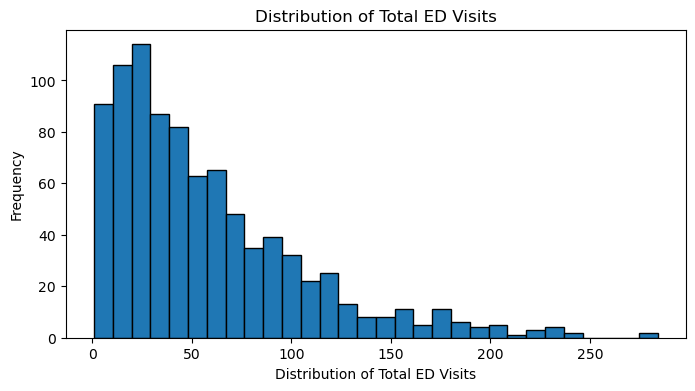

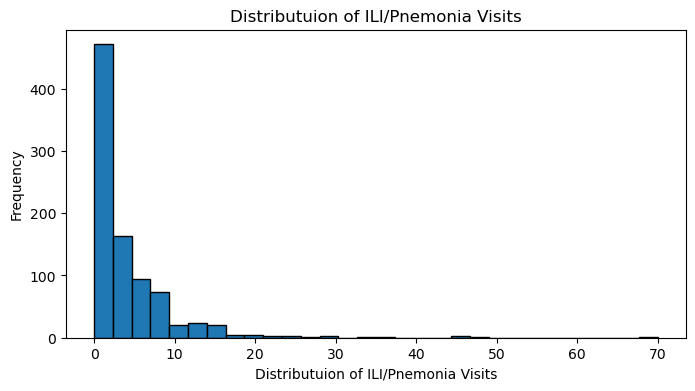

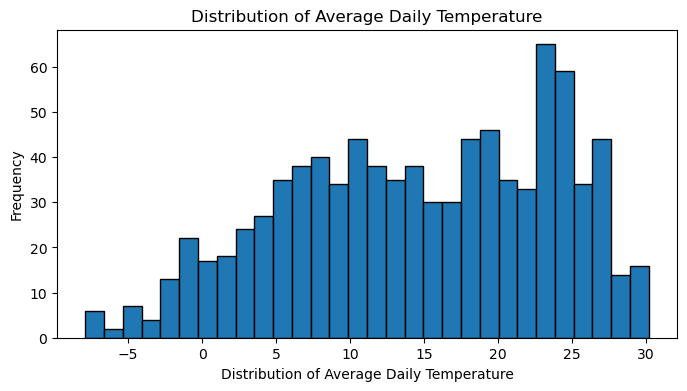

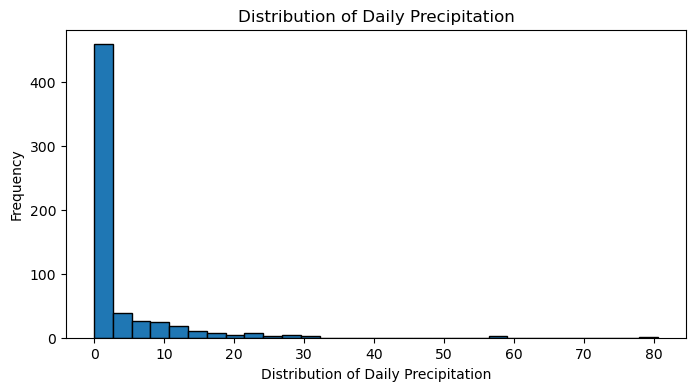

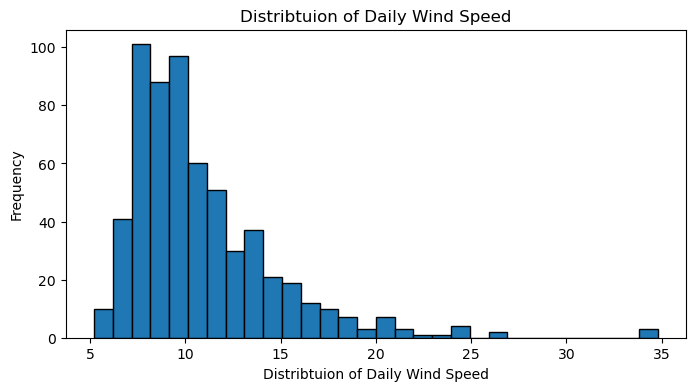

In [61]:
import matplotlib.pyplot as plt

#ed visits
plot_hist(df_final["total_ed_visits"], "Distribution of Total ED Visits")

#Flu/pnemonia visits
plot_hist(df_final["ili_pne_visits"], "Distributuion of ILI/Pnemonia Visits")

#average temp
plot_hist(df_final["tavg"], "Distribution of Average Daily Temperature")

#precipitation
plot_hist(df_final["prcp"], "Distribution of Daily Precipitation")

#wind speed
plot_hist(df_final["wspd"], "Distribtuion of Daily Wind Speed")



### 3.4 Time Series Plots

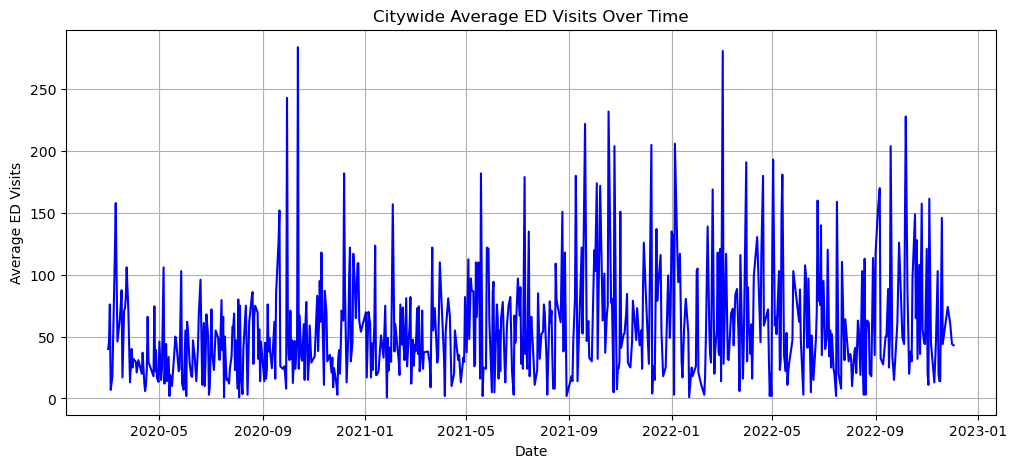

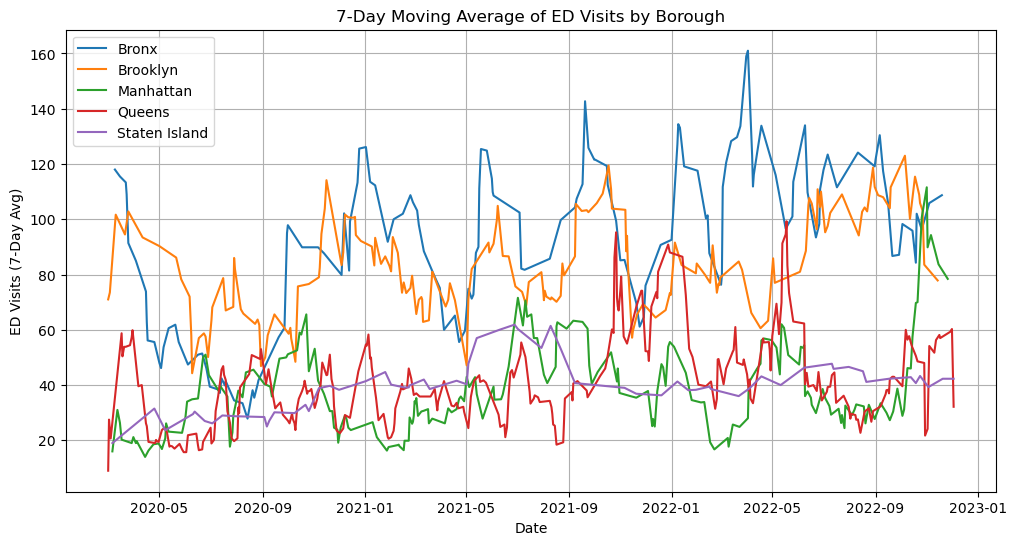

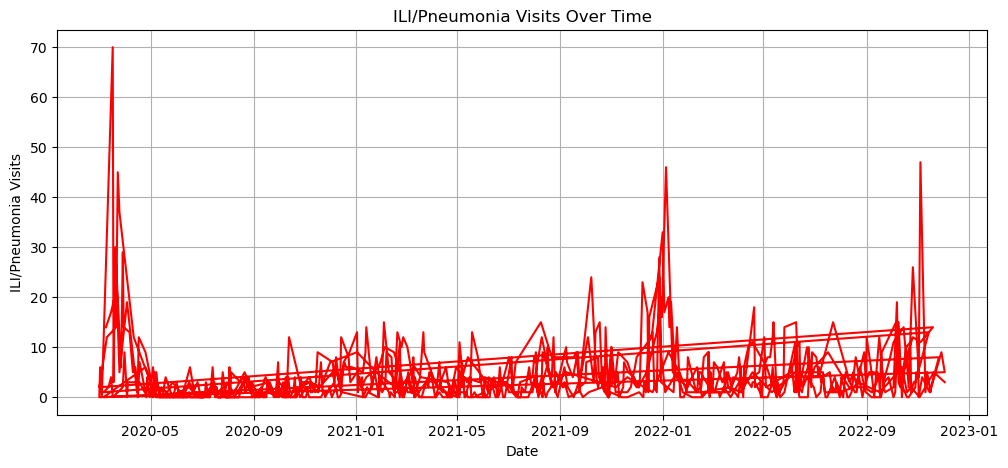

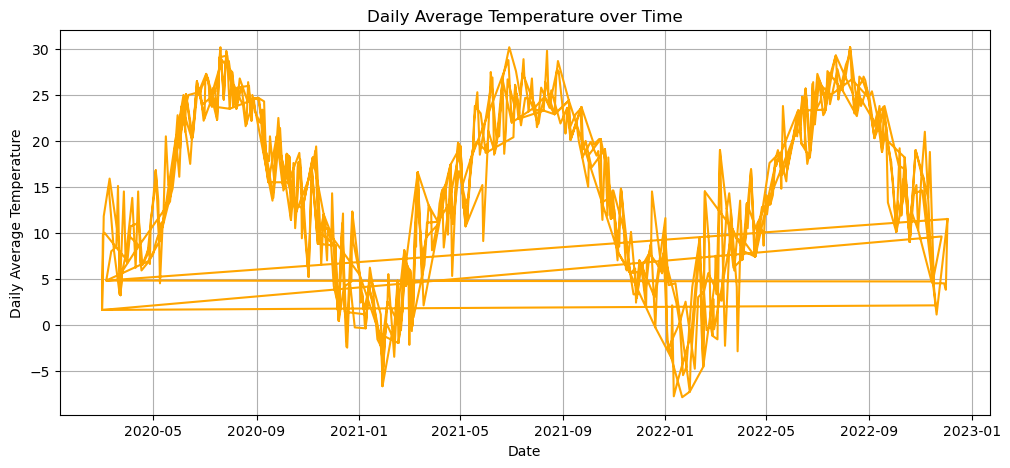

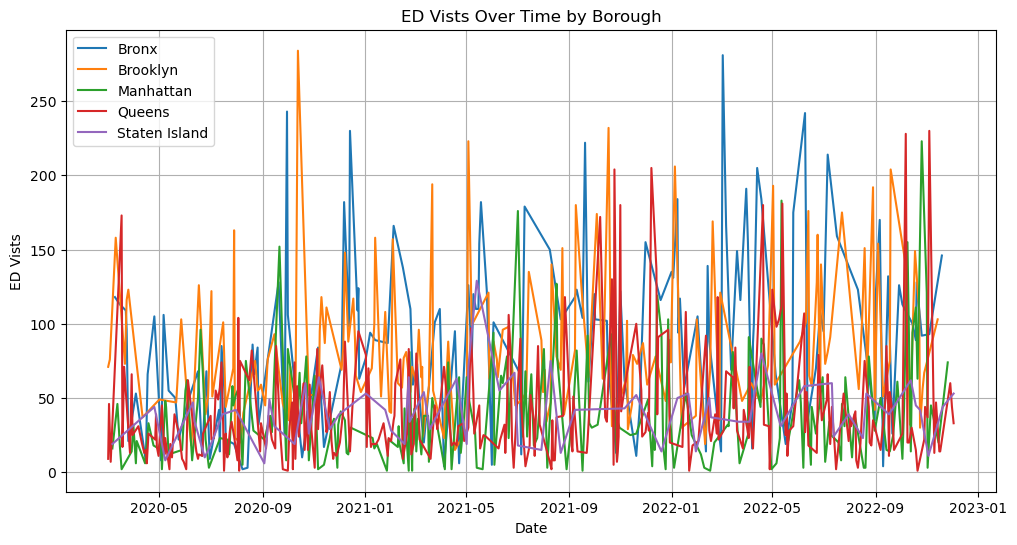

In [62]:
import matplotlib.pyplot as plt

# citywaude average ed vistis
citywide = df_final.groupby("date")["total_ed_visits"].mean().reset_index()

plt.figure(figsize=(12,5))
plt.plot(citywide["date"], citywide["total_ed_visits"], color='blue')
plt.title("Citywide Average ED Visits Over Time")
plt.xlabel("Date")
plt.ylabel("Average ED Visits")
plt.grid(True)
plt.show()


# Pretyy and clean time sereis
df_final["ed_7day"] = df_final.groupby("borough")["total_ed_visits"].transform(
    lambda x: x.rolling(7, min_periods=1).mean()
)

plt.figure(figsize=(12,6))

for b in df_final["borough"].unique():
    subset = df_final[df_final["borough"] == b]
    plt.plot(subset["date"], subset["ed_7day"], label=b)

plt.title("7-Day Moving Average of ED Visits by Borough")
plt.xlabel("Date")
plt.ylabel("ED Visits (7-Day Avg)")
plt.legend()
plt.grid(True)
plt.show()


# ILI/Pnemonia Visits over time
plt.figure(figsize=(12,5))
plt.plot(df_final["date"], df_final["ili_pne_visits"], color='red')
plt.title("ILI/Pneumonia Visits Over Time")
plt.xlabel("Date")
plt.ylabel("ILI/Pneumonia Visits")
plt.grid(True)
plt.show()

#temperature over time
plt.figure(figsize=(12,5))
plt.plot(df_final["date"], df_final["tavg"], color='orange')
plt.title("Daily Average Temperature over Time")
plt.xlabel("Date")
plt.ylabel("Daily Average Temperature")
plt.grid(True)
plt.show()

#eD vistis by borough
plt.figure(figsize=(12,6))
for b in df_final["borough"].unique():
    subset = df_final[df_final["borough"] == b]
    plt.plot(subset["date"], subset["total_ed_visits"], label=b)

plt.title("ED Vists Over Time by Borough")
plt.xlabel("Date")
plt.ylabel("ED Vists")
plt.legend()
plt.grid(True)
plt.show()

### 3.5 Correlation Matrix 

===== CORRELATION MATRIX =====
                    total_ed_visits  ili_pne_visits  ili_pne_admissions  \
total_ed_visits            1.000000        0.614193            0.377489   
ili_pne_visits             0.614193        1.000000            0.713038   
ili_pne_admissions         0.377489        0.713038            1.000000   
tavg                      -0.016042       -0.163585           -0.213272   
tmin                      -0.005386       -0.148640           -0.202199   
tmax                      -0.021847       -0.169613           -0.212557   
prcp                      -0.020087       -0.039872           -0.016626   
wspd                      -0.109555       -0.079666            0.074480   
pres                      -0.010347        0.023394           -0.049153   
weekday_num               -0.143483       -0.078109           -0.067559   
is_weekend                -0.101040       -0.046535           -0.043475   
month                      0.053250       -0.034118           -0.1306

<function matplotlib.pyplot.show(close=None, block=None)>

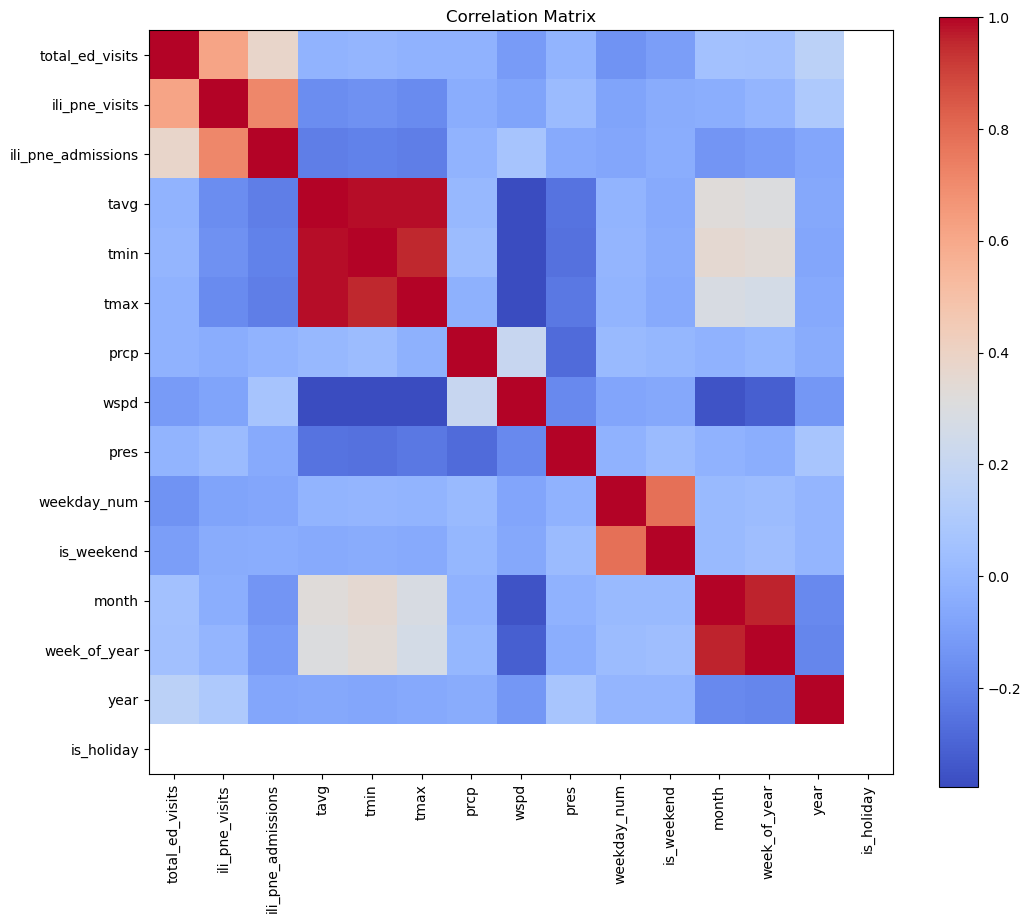

In [63]:
import numpy as np
import matplotlib.pyplot as plt

# ONLY NUMERiC COLUMNS
numeric_cols = [
    "total_ed_visits",
    "ili_pne_visits",
    "ili_pne_admissions",
    "tavg", "tmin", "tmax",
    "prcp", "wspd", "pres",
    "weekday_num", "is_weekend",
    "month", "week_of_year", "year",
    "is_holiday"
]

corr_matrix = df_final[numeric_cols].corr()

print("===== CORRELATION MATRIX =====")
print(corr_matrix)


# HEATMAP
plt.figure(figsize=(12,10))
plt.imshow(corr_matrix, cmap="coolwarm", interpolation="nearest")
plt.colorbar()
plt.xticks(range(len(numeric_cols)), numeric_cols, rotation=90)
plt.yticks(range(len(numeric_cols)), numeric_cols)
plt.title("Correlation Matrix")
plt.show


### 3.6 Scatter Plots

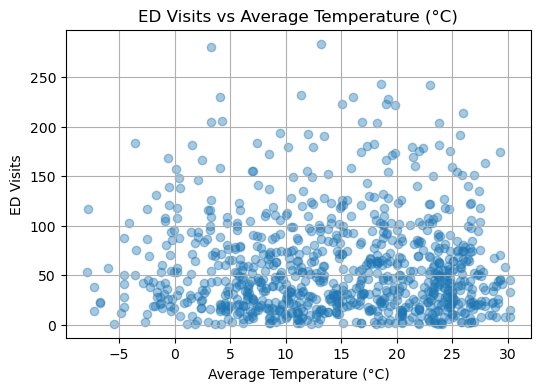

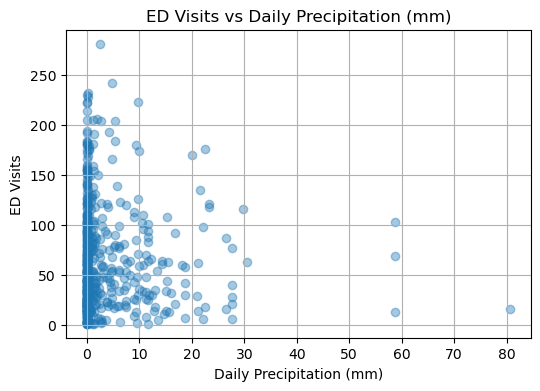

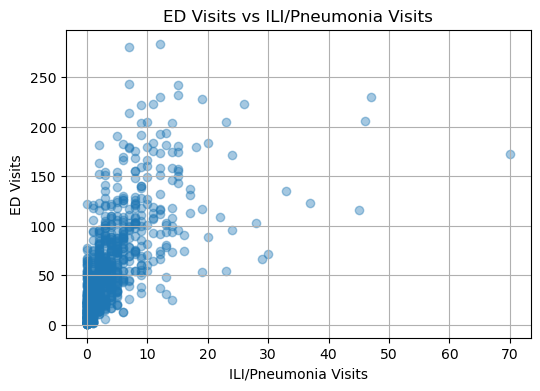

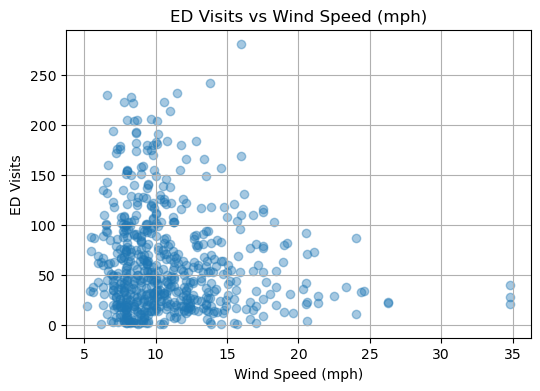

In [64]:
def scatter(x, y, xlabel, ylabel):
    plt.figure(figsize=(6,4))
    plt.scatter(df_final[x], df_final[y], alpha=0.4)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(f"{ylabel} vs {xlabel}")
    plt.grid(True)
    plt.show()

# ED vs Temperature
scatter("tavg", "total_ed_visits", "Average Temperature (°C)", "ED Visits")

# ED vs Precipitation
scatter("prcp", "total_ed_visits", "Daily Precipitation (mm)", "ED Visits")

# ED vs ILI
scatter("ili_pne_visits", "total_ed_visits", "ILI/Pneumonia Visits", "ED Visits")

# ED vs Wind Speed
scatter("wspd", "total_ed_visits", "Wind Speed (mph)", "ED Visits")

## Section 4 - Feature Engineering

### 4.1 Lag Features + Rolling Averages + One Hot Categorical Encoding

In [65]:
df_final = df_final.sort_values(["borough", "date"])

#illness lag
df_final["ili_lag1"] = df_final.groupby("borough")["ili_pne_visits"].shift(1)
df_final["ili_lag7"] = df_final.groupby("borough")["ili_pne_visits"].shift(7)

# ed visti lag
df_final["ed_lag1"] = df_final.groupby("borough")["total_ed_visits"].shift(1)
df_final["ed_lag7"] = df_final.groupby("borough")["total_ed_visits"].shift(7)

# weather lags
df_final["tavg_lag1"] = df_final.groupby("borough")["tavg"].shift(1)
df_final["prcp_lag1"] = df_final.groupby("borough")["prcp"].shift(1)



#  rolling averages! ;)
# hi if u see this ;P
#ds is fun
df_final["ili_7d_avg"] = (
    df_final.groupby("borough")["ili_pne_visits"]
    .rolling(7, min_periods=1)
    .mean()
    .reset_index(level=0, drop=True)
)

df_final["tavg_7d_avg"] = (
    df_final.groupby("borough")["tavg"]
    .rolling(7, min_periods=1)
    .mean()
    .reset_index(level=0, drop=True)
)

df_final["prcp_7d_sum"] = (
    df_final.groupby("borough")["prcp"]
    .rolling(7, min_periods=1)
    .sum()
    .reset_index(level=0, drop=True)
)

df_clean = df_final.copy()

df_final = pd.get_dummies(
    df_final,
    columns=["borough", "day_of_week", "season"],
    drop_first=True
)

#drop missing lag rows
df_final = df_final.dropna().reset_index(drop=True)


print(df_final.shape)
print(df_final.head())




(603, 39)
        date  total_ed_visits  ili_pne_visits  ili_pne_admissions  tavg  tmin  \
0 2021-01-07               94               2                   1   1.5  -1.0   
1 2021-01-13               89               4                   2   4.1   2.0   
2 2021-01-28               87               6                   2  -2.5  -7.0   
3 2021-02-04              166              10                   3   2.5  -1.0   
4 2021-02-15              138               9                   3   0.5  -1.0   

   tmax  prcp  wspd    pres  ...  borough_Staten Island  day_of_week_Monday  \
0   5.0   0.0  13.7  1019.2  ...                  False               False   
1   6.0   0.0   9.0  1016.3  ...                  False               False   
2   1.0   0.0  24.0  1019.1  ...                  False               False   
3   6.0   0.0  12.1  1010.5  ...                  False               False   
4   2.0   1.1  11.0  1022.4  ...                  False                True   

   day_of_week_Saturday  day

## Section 5 - Statistical Tests

### 5.1 - Correlation Tests (Pearson + Spearman)

In [66]:
import pandas as pd

numeric_cols = [
    "total_ed_visits",
    "ili_pne_visits",
    "ili_pne_admissions",
    "tavg", "tmin", "tmax",
    "prcp", "wspd", "pres",
    "weekday_num", "is_weekend",
    "month", "week_of_year", "year",
    "is_holiday"
]

#compute pearsons
pearson_corr = df_final[numeric_cols].corr(method="pearson")

#select desired columns
pearson_with_ed = pearson_corr["total_ed_visits"].sort_values(ascending=False)

#print(pearson_with_ed)

spearman_corr = df_final[numeric_cols].corr(method="spearman")

spearman_with_ed = spearman_corr["total_ed_visits"].sort_values(ascending=False)

#print(spearman_with_ed)


corr_table = pd.DataFrame({
    "Pearson": pearson_with_ed,
    "Spearman": spearman_with_ed
})

print("\n==================== Combined Correlation Table ====================")
print(corr_table)








==================== Combined Correlation Table ====================
                     Pearson  Spearman
ili_pne_admissions  0.419215  0.473031
ili_pne_visits      0.709620  0.798738
is_holiday               NaN       NaN
is_weekend         -0.101188 -0.081974
month               0.065315  0.067515
prcp               -0.020822  0.035182
pres               -0.008762 -0.011794
tavg                0.042827  0.034003
tmax                0.037631  0.023535
tmin                0.047988  0.046857
total_ed_visits     1.000000  1.000000
week_of_year        0.062685  0.064575
weekday_num        -0.138738 -0.139624
wspd               -0.112444 -0.077431
year                0.058480  0.028190


### 5.2 T-Tests

In [67]:
from scipy import stats

# seperate teh samples
weekday = df_final.loc[df_final["is_weekend"] == 0, "total_ed_visits"]
weekend = df_final.loc[df_final["is_weekend"] == 1, "total_ed_visits"]

#welchs ttest
t1, p1 = stats.ttest_ind(weekday,weekend,equal_var=False)

# Welch's t-test
t1, p1 = stats.ttest_ind(weekday, weekend, equal_var=False)

print("\n=== T-TEST 1: Weekend vs Weekday ===")
print(f"Weekday mean: {weekday.mean():.2f}")
print(f"Weekend mean: {weekend.mean():.2f}")
print(f"t-statistic: {t1:.3f}")
print(f"p-value: {p1:.6f}")


q1 = df_final["ili_pne_visits"].quantile(0.25)
q3 = df_final["ili_pne_visits"].quantile(0.75)

#low +high groups
low_ili = df_final.loc[df_final["ili_pne_visits"] <= q1, "total_ed_visits"] # 25th percentile
high_ili = df_final.loc[df_final["ili_pne_visits"] >= q3, "total_ed_visits"] # 75th percentile

t3, p3 = stats.ttest_ind(high_ili, low_ili, equal_var=False)


print("\n=== T-TEST 2: High ILI vs Low ILI ===")
print(f"Low ILI mean ED visits: {low_ili.mean():.2f}")
print(f"High ILI mean ED visits: {high_ili.mean():.2f}")
print(f"t-statistic: {t3:.3f}")
print(f"p-value: {p3:.6f}")




=== T-TEST 1: Weekend vs Weekday ===
Weekday mean: 65.52
Weekend mean: 53.68
t-statistic: 2.796
p-value: 0.005482

=== T-TEST 2: High ILI vs Low ILI ===
Low ILI mean ED visits: 23.44
High ILI mean ED visits: 120.89
t-statistic: 23.184
p-value: 0.000000


### 5.3 ANOVA Tests

In [68]:
import scipy.stats as stats
import pandas as pd


df_final["season"] = df_final["month"].apply(get_season)

# Copy of your cleaned analysis dataset
df_anova = df_clean.copy()


print("========== ANOVA 1: ED Visits Across Seasons ==========")

groups = [group["total_ed_visits"].values 
          for name, group in df_anova.groupby("season")]

f_stat, p_val = stats.f_oneway(*groups)

print("F-statistic:", f_stat)
print("p-value:", p_val)
print("\nGroup means:")
print(df_anova.groupby("season")["total_ed_visits"].mean())
print("\n---------------------------------------------\n")

print("========== ANOVA 2: ED Visits Across Months ==========")

groups = [group["total_ed_visits"].values 
          for name, group in df_anova.groupby("month")]

f_stat, p_val = stats.f_oneway(*groups)

print("F-statistic:", f_stat)
print("p-value:", p_val)
print("\nGroup means:")
print(df_anova.groupby("month")["total_ed_visits"].mean())
print("\n---------------------------------------------\n")



print("========== ANOVA 3: ED Visits Across Boroughs ==========")

groups = [group["total_ed_visits"].values 
          for name, group in df_anova.groupby("borough")]

f_stat, p_val = stats.f_oneway(*groups)

print("F-statistic:", f_stat)
print("p-value:", p_val)
print("\nGroup means:")
print(df_anova.groupby("borough")["total_ed_visits"].mean())
print("\n---------------------------------------------\n")


========== ANOVA 1: ED Visits Across Seasons ==========
F-statistic: 1.6634129055066833
p-value: 0.17333626957600654

Group means:
season
Fall      61.761905
Spring    56.405983
Summer    52.742308
Winter    60.401198
Name: total_ed_visits, dtype: float64

---------------------------------------------

========== ANOVA 2: ED Visits Across Months ==========
F-statistic: 1.403939682974971
p-value: 0.16543657176149823

Group means:
month
1     58.854167
2     52.919355
3     62.345679
4     46.320000
5     59.935897
6     54.910112
7     50.505495
8     52.875000
9     62.957143
10    65.274725
11    56.000000
12    69.842105
Name: total_ed_visits, dtype: float64

---------------------------------------------

========== ANOVA 3: ED Visits Across Boroughs ==========
F-statistic: 63.46751536067574
p-value: 3.3000870353813926e-47

Group means:
borough
Bronx            92.695946
Brooklyn         82.899441
Manhattan        39.043689
Queens           40.945946
Staten Island    40.396825
Name: 

### 5.4 Seasonal Decomposition

<Figure size 1200x800 with 0 Axes>

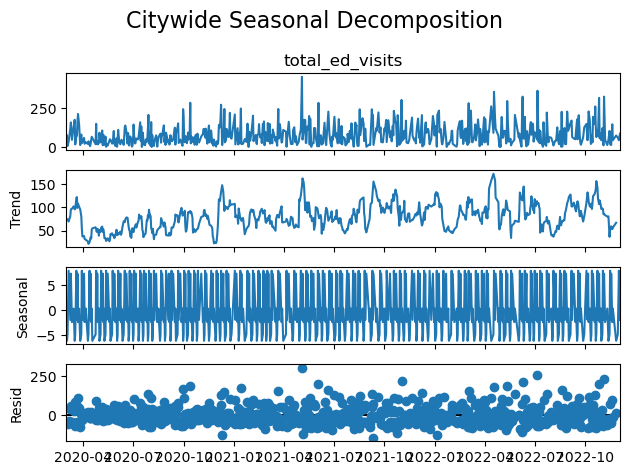

<Figure size 1200x800 with 0 Axes>

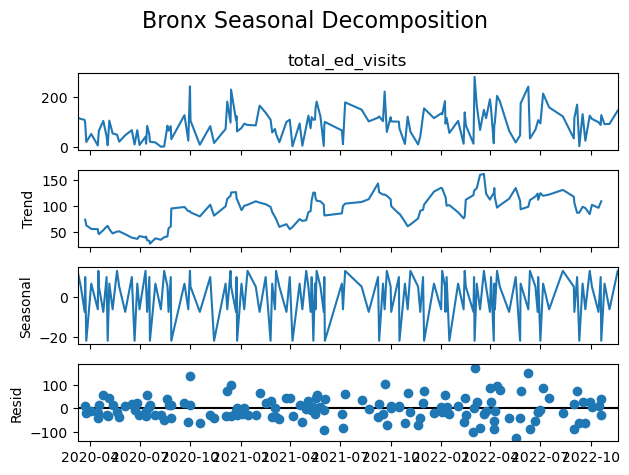

<Figure size 1200x800 with 0 Axes>

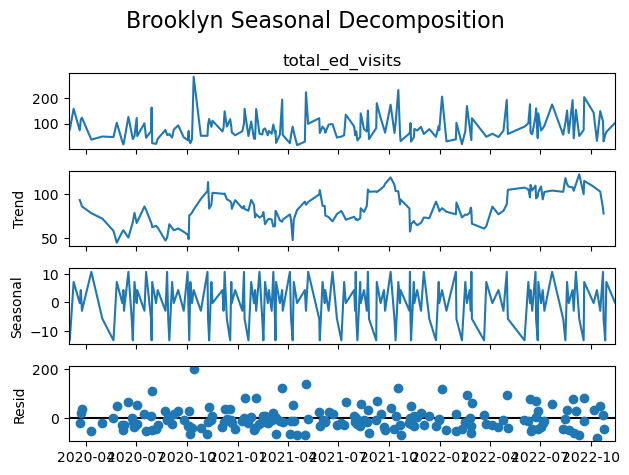

<Figure size 1200x800 with 0 Axes>

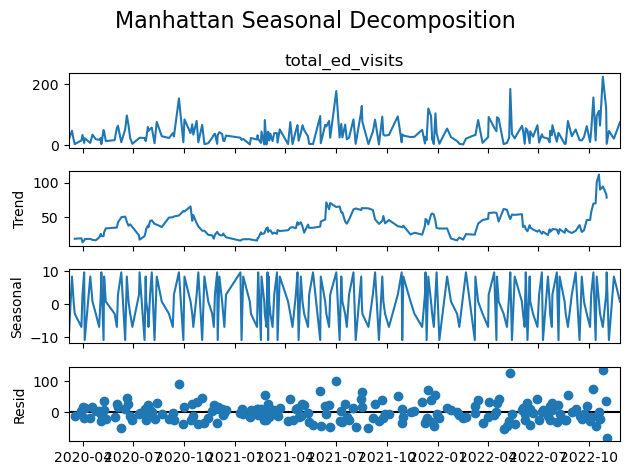

<Figure size 1200x800 with 0 Axes>

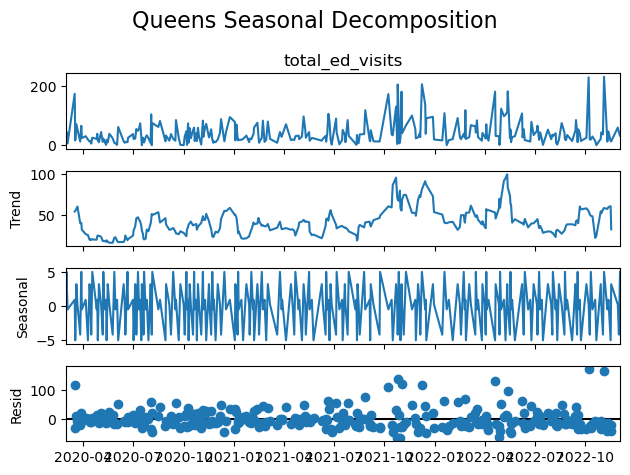

<Figure size 1200x800 with 0 Axes>

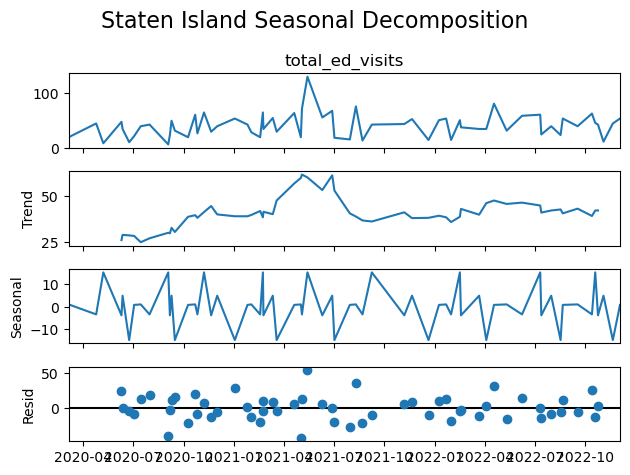

In [69]:
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Ensure datetime index
df_final = df_clean.copy()
df_final = df_final.sort_values(["borough", "date"])
df_final.set_index("date", inplace=True)

# Citywide daily total
city_ts = df_final.groupby(df_final.index)["total_ed_visits"].sum()

# Decompose (additive is standard)
decomp_city = seasonal_decompose(city_ts, model="additive", period=7)

plt.figure(figsize=(12,8))
decomp_city.plot()
plt.suptitle("Citywide Seasonal Decomposition", fontsize=16)
plt.tight_layout()
plt.show()

for b in df_final["borough"].unique():
    boro_data = df_final[df_final["borough"] == b]["total_ed_visits"]

    decomp = seasonal_decompose(boro_data, model="additive", period=7)

    plt.figure(figsize=(12,8))
    decomp.plot()
    plt.suptitle(f"{b} Seasonal Decomposition", fontsize=16)
    plt.tight_layout()
    plt.show()



### 5.6 ACF & PACF 

<Figure size 1000x400 with 0 Axes>

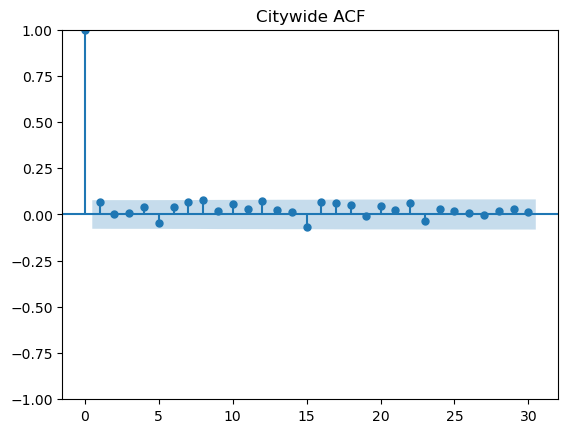

<Figure size 1000x400 with 0 Axes>

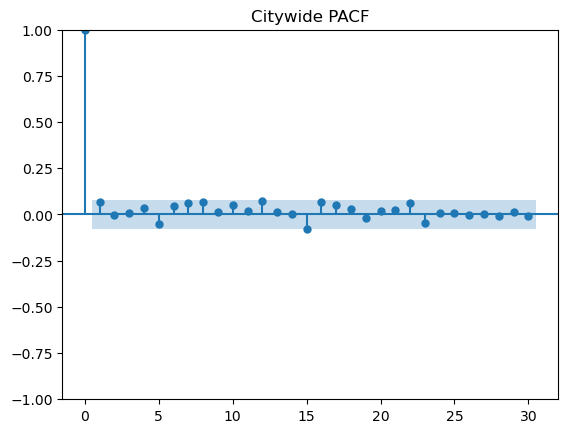

<Figure size 1000x400 with 0 Axes>

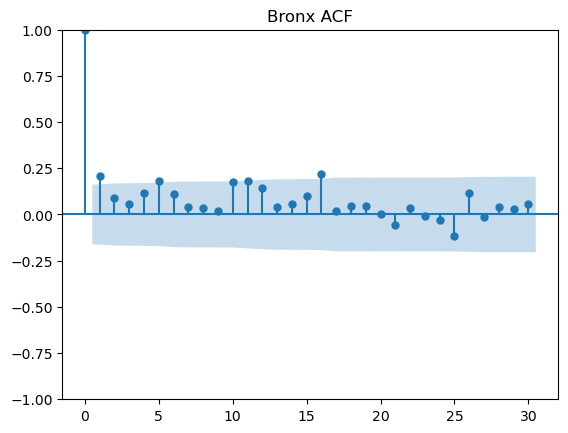

<Figure size 1000x400 with 0 Axes>

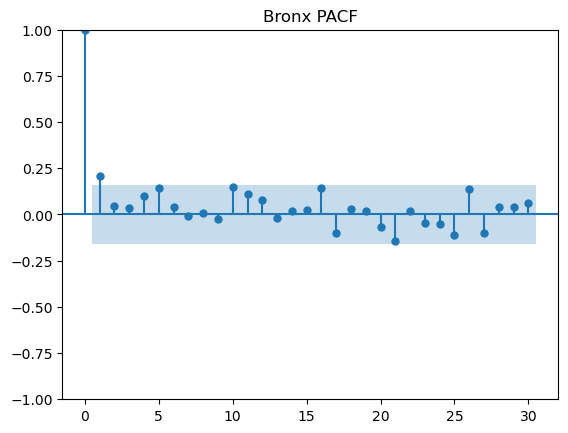

<Figure size 1000x400 with 0 Axes>

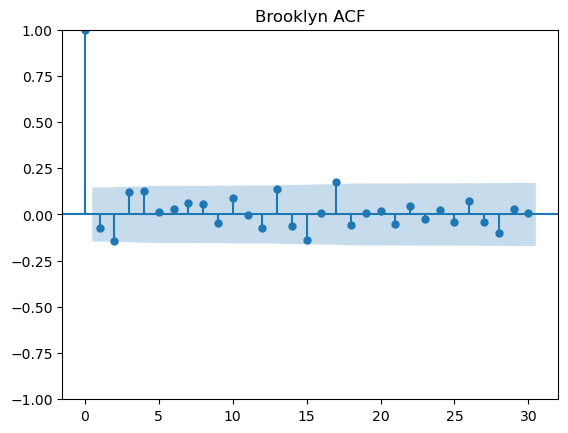

<Figure size 1000x400 with 0 Axes>

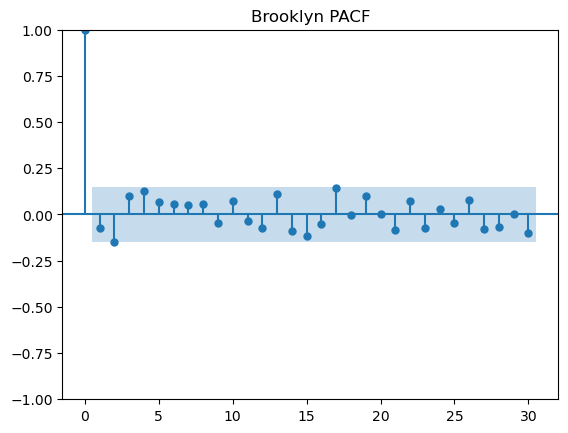

<Figure size 1000x400 with 0 Axes>

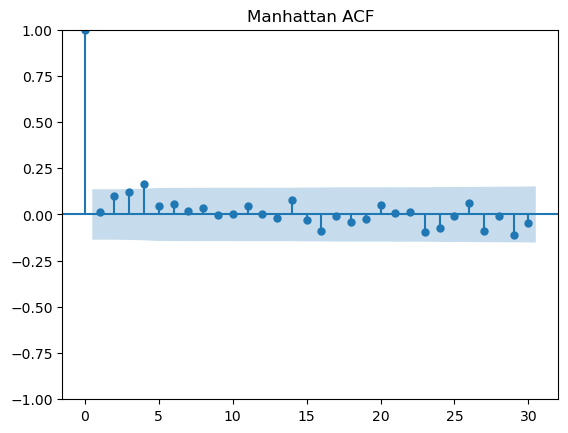

<Figure size 1000x400 with 0 Axes>

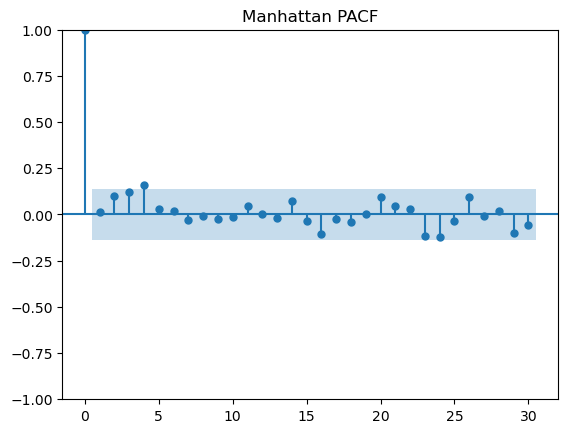

<Figure size 1000x400 with 0 Axes>

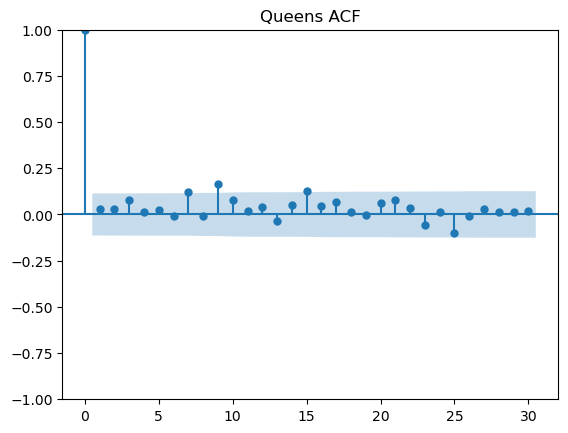

<Figure size 1000x400 with 0 Axes>

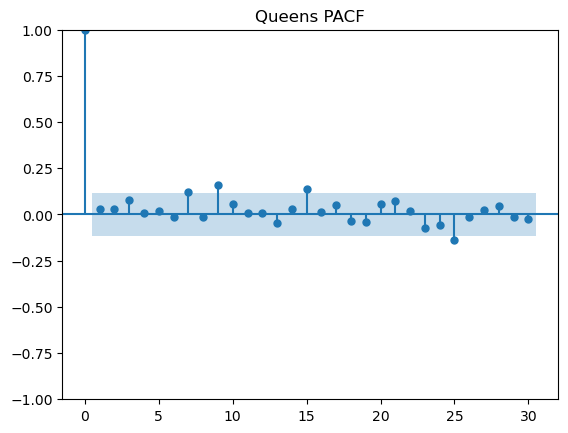

<Figure size 1000x400 with 0 Axes>

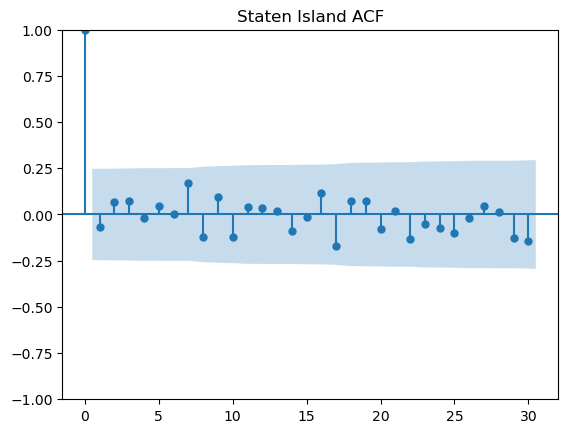

<Figure size 1000x400 with 0 Axes>

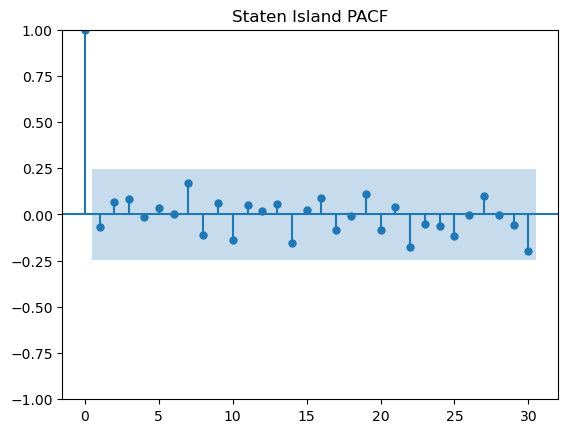

In [70]:
plt.figure(figsize=(10,4))
plot_acf(city_ts, lags=30)
plt.title("Citywide ACF")
plt.show()

plt.figure(figsize=(10,4))
plot_pacf(city_ts, lags=30, method='ywm')
plt.title("Citywide PACF")
plt.show()



for b in df_final["borough"].unique():
    series = df_final[df_final["borough"] == b]["total_ed_visits"]

    plt.figure(figsize=(10,4))
    plot_acf(series, lags=30)
    plt.title(f"{b} ACF")
    plt.show()

    plt.figure(figsize=(10,4))
    plot_pacf(series, lags=30, method='ywm')
    plt.title(f"{b} PACF")
    plt.show()


## Section 6 - Modeling

### 6.1 Model 1 - Multiple Linear Regression

In [71]:
df_model = df_final.copy()

# fix missing values
import numpy as np
import pandas as pd

df_model = df_model.replace({pd.NA: np.nan})

# Fill weather missing values
df_model["prcp"] = df_model["prcp"].fillna(0)   # missing rain = 0
df_model["wspd"] = df_model["wspd"].fillna(df_model["wspd"].median())
df_model["pres"] = df_model["pres"].fillna(df_model["pres"].median())

# Fill any remaining NaN in lags or other columns
df_model = df_model.fillna(df_model.median(numeric_only=True))

# fix borough (bronx)
df_model = pd.get_dummies(
    df_model,
    columns=["borough", "day_of_week", "season"],
    drop_first=True
)




# Training
df_model = df_model.sort_values("date")

#80/10 split
split_idx = int(len(df_model) * 0.8)

train = df_model.iloc[:split_idx]
test  = df_model.iloc[split_idx:]

X_train = train.drop(columns=["total_ed_visits"])
y_train = train["total_ed_visits"]

X_test = test.drop(columns=["total_ed_visits"])
y_test = test["total_ed_visits"]

print(X_train.shape, X_test.shape)

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Train model
linreg = LinearRegression()
linreg.fit(X_train, y_train)

# Predict
y_pred_lr = linreg.predict(X_test)

# Evaluation
rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))
mae_lr = mean_absolute_error(y_test, y_pred_lr)
r2_lr = r2_score(y_test, y_pred_lr)

print("Linear Regression Results:")
print("RMSE:", rmse_lr)
print("MAE:", mae_lr)
print("R²:", r2_lr)



(713, 37) (179, 37)
Linear Regression Results:
RMSE: 29.476235411801028
MAE: 21.917982575263135
R²: 0.7051312753638809


### 6.2 Model 2 - Random Forest Regression (Nonlinear ML Model)

In [72]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import pandas as pd

# Training RF
rf = RandomForestRegressor(
    n_estimators=400,     # 400 trees = stable
    max_depth=12,         # prevents overfitting
    min_samples_split=5,
    min_samples_leaf=3,
    random_state=42,
    n_jobs=-1             # use all CPU cores
)

rf.fit(X_train, y_train)

# Predict
y_pred_rf = rf.predict(X_test)

# Evaluate
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
mae_rf  = mean_absolute_error(y_test, y_pred_rf)
r2_rf   = r2_score(y_test, y_pred_rf)

print("===== RANDOM FOREST RESULTS =====")
print("RMSE:", rmse_rf)
print("MAE :", mae_rf)
print("R²   :", r2_rf)

# 
importances = pd.DataFrame({
    "Feature": X_train.columns,
    "Importance": rf.feature_importances_
}).sort_values("Importance", ascending=False)

print("\n===== TOP 20 IMPORTANT FEATURES =====")
print(importances.head(20))


===== RANDOM FOREST RESULTS =====
RMSE: 30.291519979383242
MAE : 21.83438336167906
R²   : 0.6885941184840134

===== TOP 20 IMPORTANT FEATURES =====
             Feature  Importance
0     ili_pne_visits    0.492135
14           ed_7day    0.199996
21        ili_7d_avg    0.056461
15          ili_lag1    0.021480
18           ed_lag7    0.021447
17           ed_lag1    0.018038
19         tavg_lag1    0.017166
8        weekday_num    0.015847
24  borough_Brooklyn    0.014869
6               wspd    0.014786
4               tmax    0.012466
22       tavg_7d_avg    0.011843
20         prcp_lag1    0.011721
7               pres    0.011031
16          ili_lag7    0.010942
2               tavg    0.010157
23       prcp_7d_sum    0.009847
12      week_of_year    0.009492
3               tmin    0.007708
5               prcp    0.006309


### 6.3 Model 3 - Gradient Boosting Regression (Predictive Accuracy Model)

In [73]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Train GB MOdel
gbr = GradientBoostingRegressor(
    n_estimators=500,     # more trees = better smoothing
    learning_rate=0.03,   # small learning rate = slower but more stable
    max_depth=4,          # each tree can capture moderate interactions
    subsample=0.8,        # like random forest but boosted
    random_state=42
)

gbr.fit(X_train, y_train)

# predict
y_pred_gbr = gbr.predict(X_test)

# evaluate
rmse_gbr = np.sqrt(mean_squared_error(y_test, y_pred_gbr))
mae_gbr  = mean_absolute_error(y_test, y_pred_gbr)
r2_gbr   = r2_score(y_test, y_pred_gbr)

print("===== GRADIENT BOOSTING RESULTS =====")
print("RMSE:", rmse_gbr)
print("MAE :", mae_gbr)
print("R²   :", r2_gbr)

# Feature importances
importances_gbr = pd.DataFrame({
    "Feature": X_train.columns,
    "Importance": gbr.feature_importances_
}).sort_values("Importance", ascending=False)

print("\n===== TOP 20 IMPORTANT FEATURES (GBR) =====")
print(importances_gbr.head(20))


===== GRADIENT BOOSTING RESULTS =====
RMSE: 30.20969661055816
MAE : 22.443259546436646
R²   : 0.6902741837093146

===== TOP 20 IMPORTANT FEATURES (GBR) =====
             Feature  Importance
0     ili_pne_visits    0.444099
14           ed_7day    0.192253
21        ili_7d_avg    0.077837
15          ili_lag1    0.030119
18           ed_lag7    0.021709
8        weekday_num    0.021313
19         tavg_lag1    0.018993
17           ed_lag1    0.018727
22       tavg_7d_avg    0.018035
6               wspd    0.015241
16          ili_lag7    0.015049
20         prcp_lag1    0.013656
2               tavg    0.013009
7               pres    0.012609
4               tmax    0.011833
24  borough_Brooklyn    0.011446
23       prcp_7d_sum    0.010374
3               tmin    0.008203
12      week_of_year    0.007993
5               prcp    0.007632


### Section 7 Model Diagnostics + Intepretation
## 7.1 Linear Regression

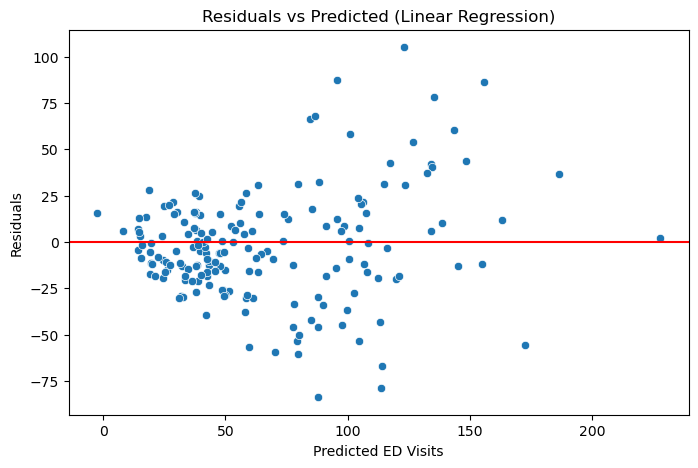

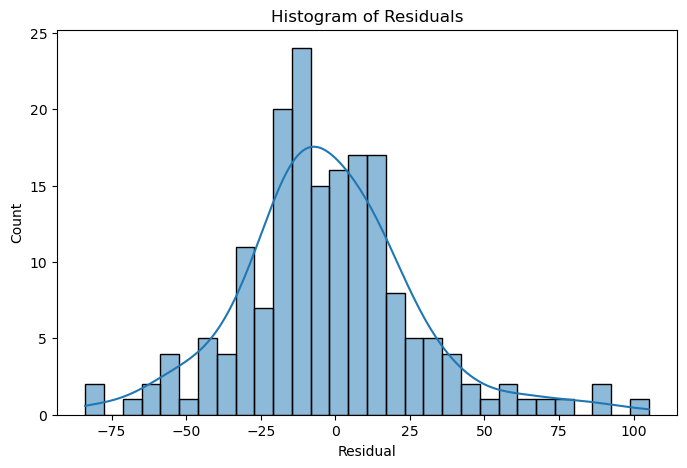

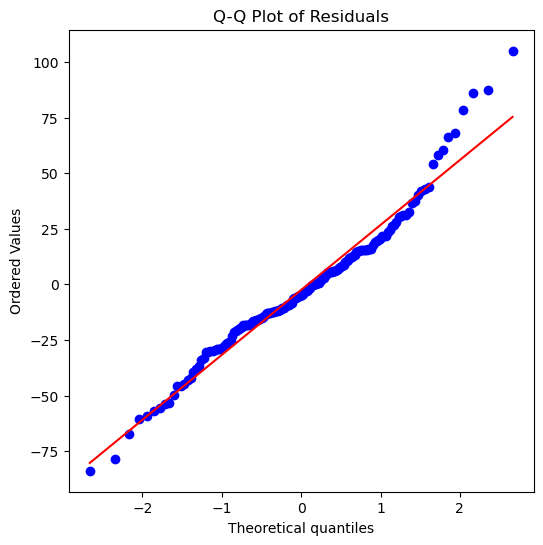

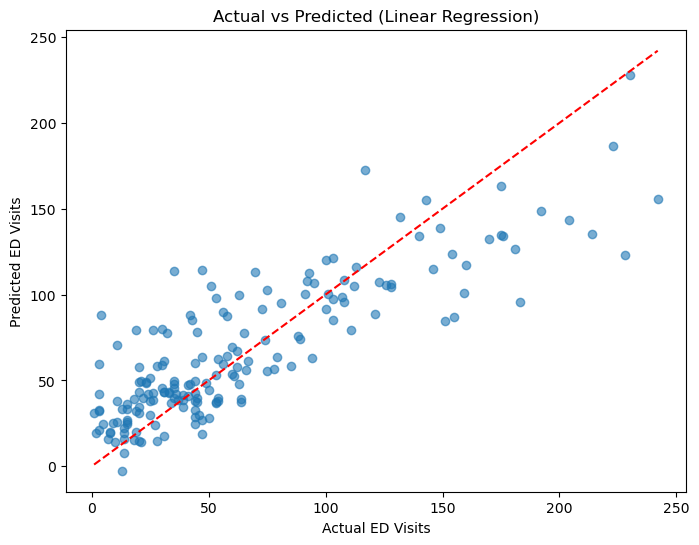

In [74]:
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

# Residuals
residuals = y_test - y_pred_lr

plt.figure(figsize=(8,5))
sns.scatterplot(x=y_pred_lr, y=residuals)
plt.axhline(0, color='red')
plt.xlabel("Predicted ED Visits")
plt.ylabel("Residuals")
plt.title("Residuals vs Predicted (Linear Regression)")
plt.show()

# Histogram
plt.figure(figsize=(8,5))
sns.histplot(residuals, kde=True, bins=30)
plt.title("Histogram of Residuals")
plt.xlabel("Residual")
plt.show()

# QQ Plot
plt.figure(figsize=(6,6))
stats.probplot(residuals, dist="norm", plot=plt)
plt.title("Q-Q Plot of Residuals")
plt.show()

# Predicted vs Actual
plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred_lr, alpha=0.6)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual ED Visits")
plt.ylabel("Predicted ED Visits")
plt.title("Actual vs Predicted (Linear Regression)")
plt.show()


## 7.2 Random Forest

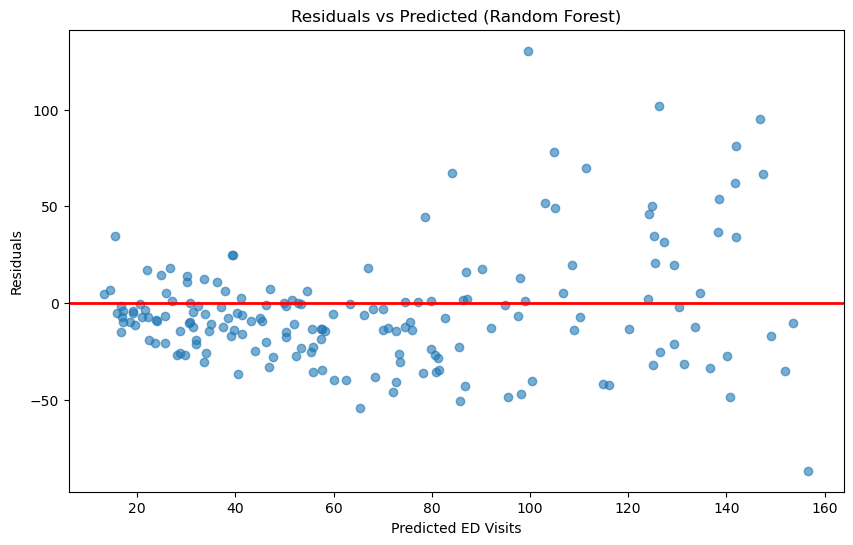

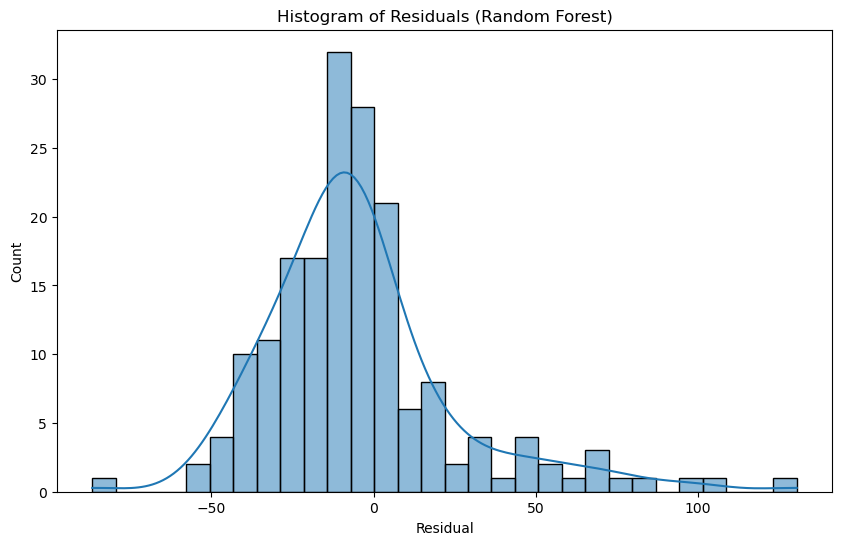

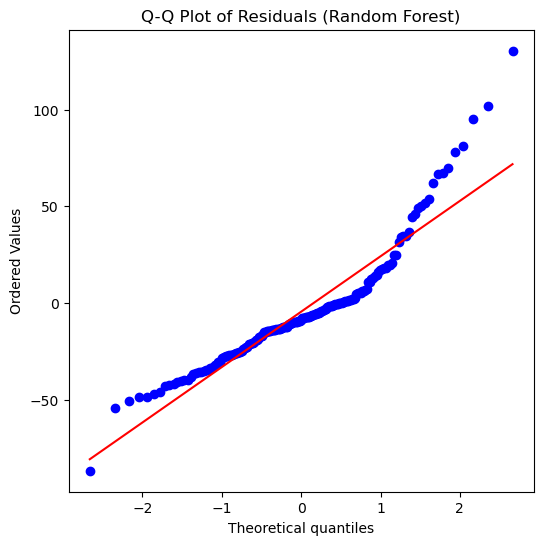

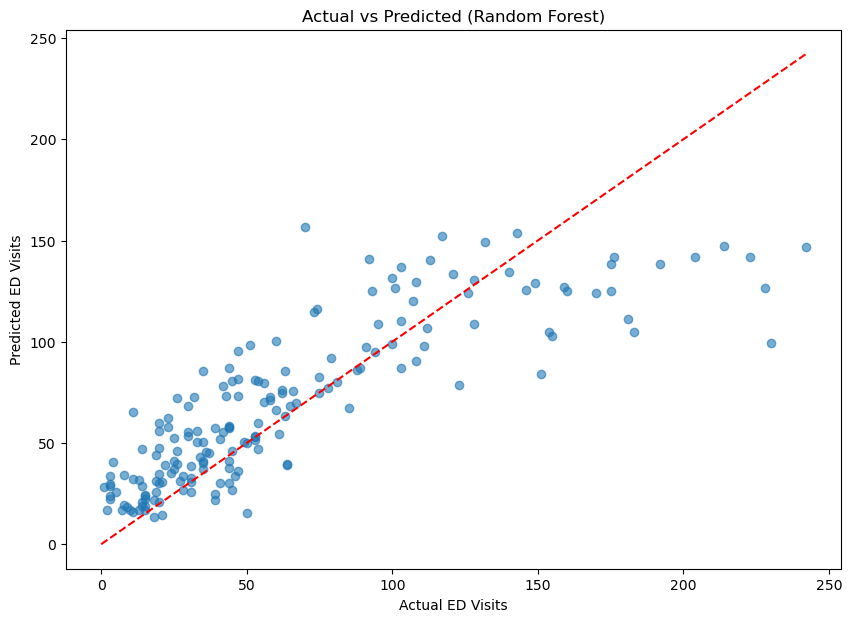

In [75]:
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import numpy as np

# Residuals
rf_residuals = y_test - y_pred_rf

# REsiduals vs PRedicted
plt.figure(figsize=(10,6))
plt.scatter(y_pred_rf, rf_residuals, alpha=0.6)
plt.axhline(0, color='red', linewidth=2)
plt.xlabel("Predicted ED Visits")
plt.ylabel("Residuals")
plt.title("Residuals vs Predicted (Random Forest)")
plt.show()

# Residual histogram
plt.figure(figsize=(10,6))
sns.histplot(rf_residuals, kde=True, bins=30)
plt.xlabel("Residual")
plt.title("Histogram of Residuals (Random Forest)")
plt.show()

# QQ plot
plt.figure(figsize=(6,6))
stats.probplot(rf_residuals, dist="norm", plot=plt)
plt.title("Q-Q Plot of Residuals (Random Forest)")
plt.show()

# aCtual vs Predicted
plt.figure(figsize=(10,7))
plt.scatter(y_test, y_pred_rf, alpha=0.6)
plt.plot([0, max(y_test)], [0, max(y_test)], color='red', linestyle='--')
plt.xlabel("Actual ED Visits")
plt.ylabel("Predicted ED Visits")
plt.title("Actual vs Predicted (Random Forest)")
plt.show()


## 7.3 GB Diagnostic

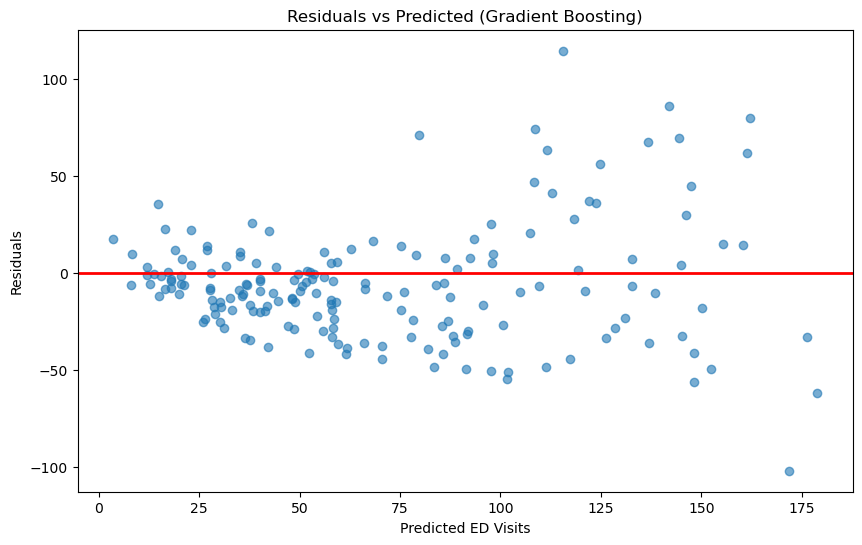

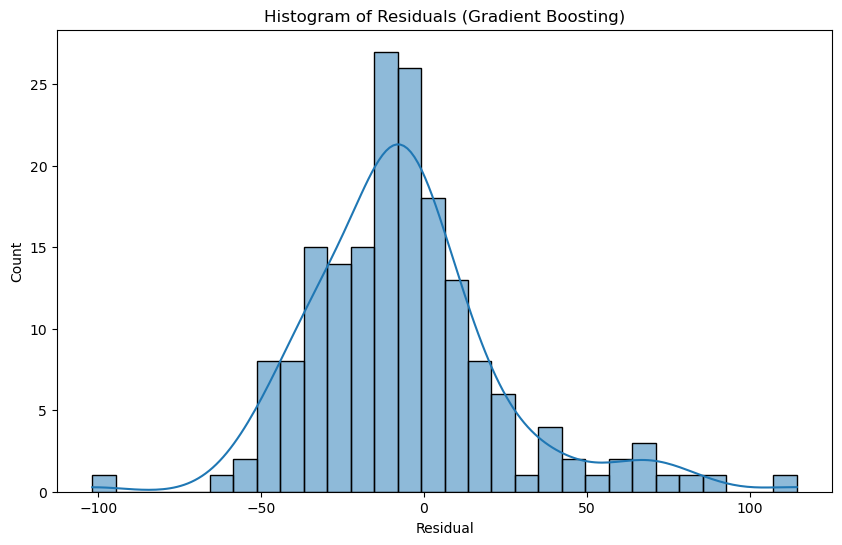

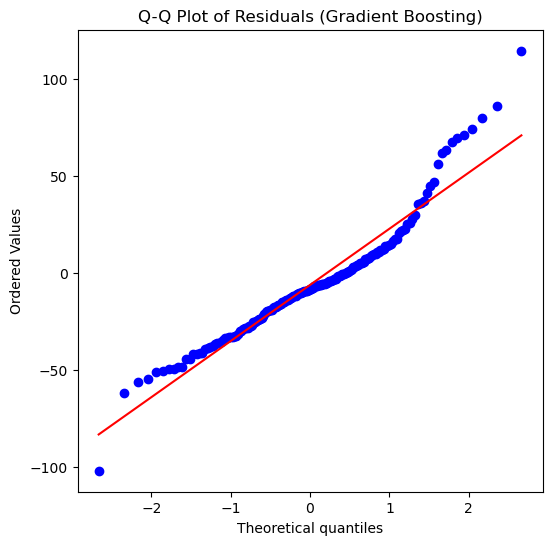

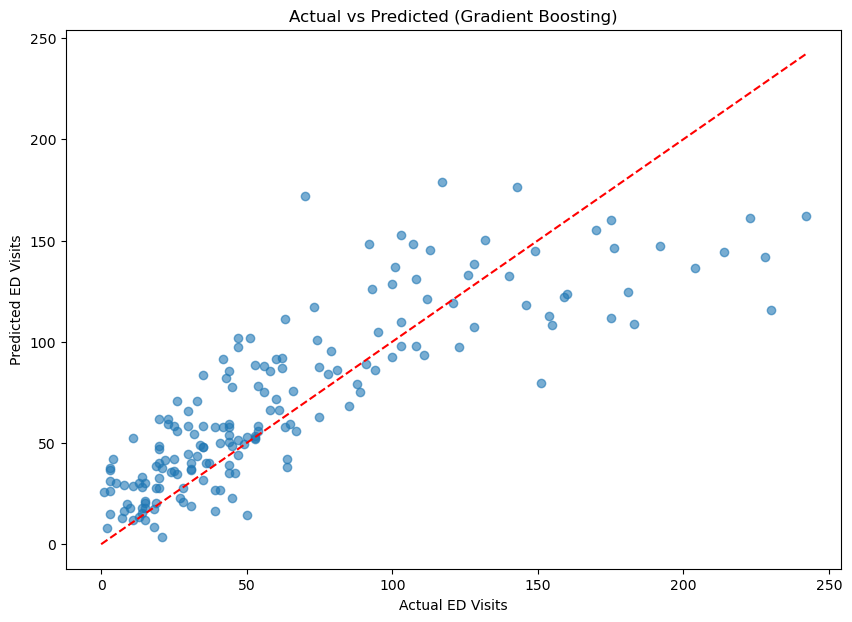

In [76]:
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import numpy as np

# Residuals
rf_residuals = y_test - y_pred_gbr

# Residuals vs Predicted
plt.figure(figsize=(10,6))
plt.scatter(y_pred_gbr, rf_residuals, alpha=0.6)
plt.axhline(0, color='red', linewidth=2)
plt.xlabel("Predicted ED Visits")
plt.ylabel("Residuals")
plt.title("Residuals vs Predicted (Gradient Boosting)")
plt.show()

# Residual histogram
plt.figure(figsize=(10,6))
sns.histplot(rf_residuals, kde=True, bins=30)
plt.xlabel("Residual")
plt.title("Histogram of Residuals (Gradient Boosting)")
plt.show()

# QQ Plot
plt.figure(figsize=(6,6))
stats.probplot(rf_residuals, dist="norm", plot=plt)
plt.title("Q-Q Plot of Residuals (Gradient Boosting)")
plt.show()

# Actual vs Predicted
plt.figure(figsize=(10,7))
plt.scatter(y_test, y_pred_gbr, alpha=0.6)
plt.plot([0, max(y_test)], [0, max(y_test)], color='red', linestyle='--')
plt.xlabel("Actual ED Visits")
plt.ylabel("Predicted ED Visits")
plt.title("Actual vs Predicted (Gradient Boosting)")
plt.show()


## Section 8 Comparison

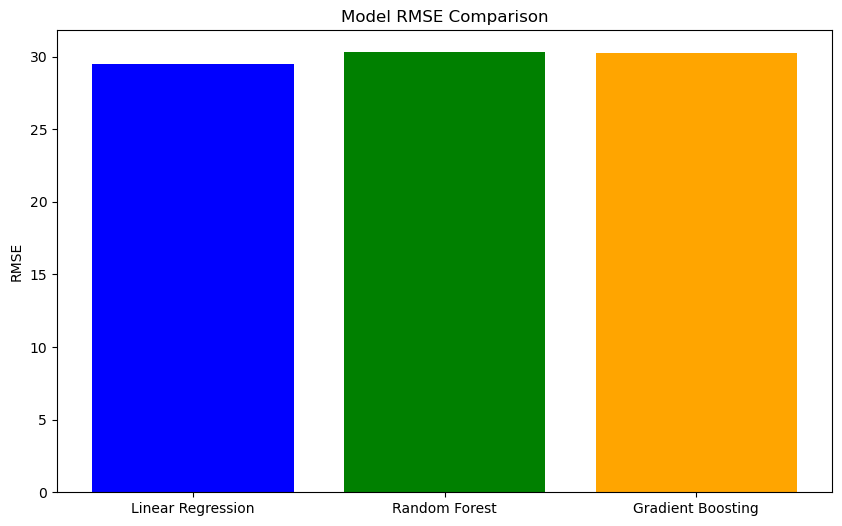

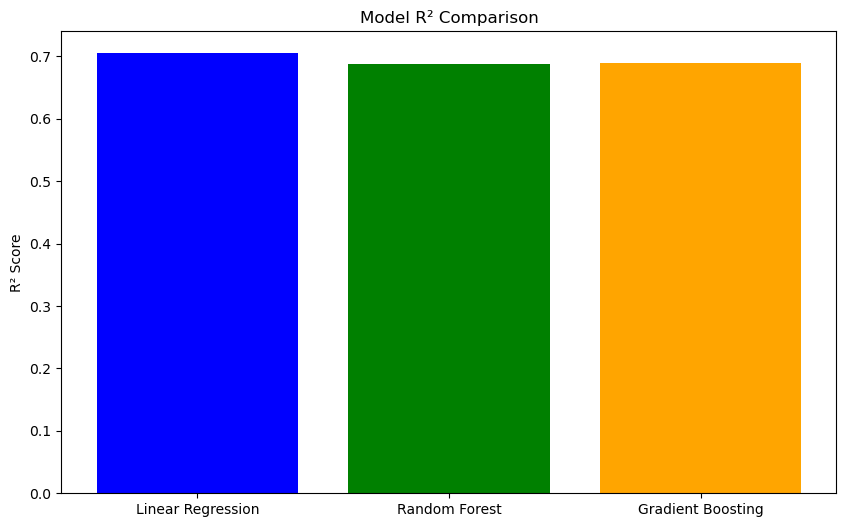

In [77]:
import pandas as pd

results = pd.DataFrame({
    "Model": ["Linear Regression", "Random Forest", "Gradient Boosting"],
    "RMSE": [rmse_lr, rmse_rf, rmse_gbr],
    "MAE": [mae_lr, mae_rf, mae_gbr],
    "R²": [r2_lr, r2_rf, r2_gbr]
})

results

import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.bar(results["Model"], results["RMSE"], color=["blue","green","orange"])
plt.title("Model RMSE Comparison")
plt.ylabel("RMSE")
plt.show()

plt.figure(figsize=(10,6))
plt.bar(results["Model"], results["R²"], color=["blue","green","orange"])
plt.title("Model R² Comparison")
plt.ylabel("R² Score")
plt.show()



## Section 11 - Prediction

        date  actual_ED_visits  predicted_ED_visits
0 2022-09-17               146                114.9
1 2022-10-13                44                 49.4
2 2022-10-19                74                 73.6
3 2022-10-24                60                 53.8
4 2022-11-03                44                 42.6
5 2022-11-20                33                 42.5
6 2022-12-03                53                 37.1


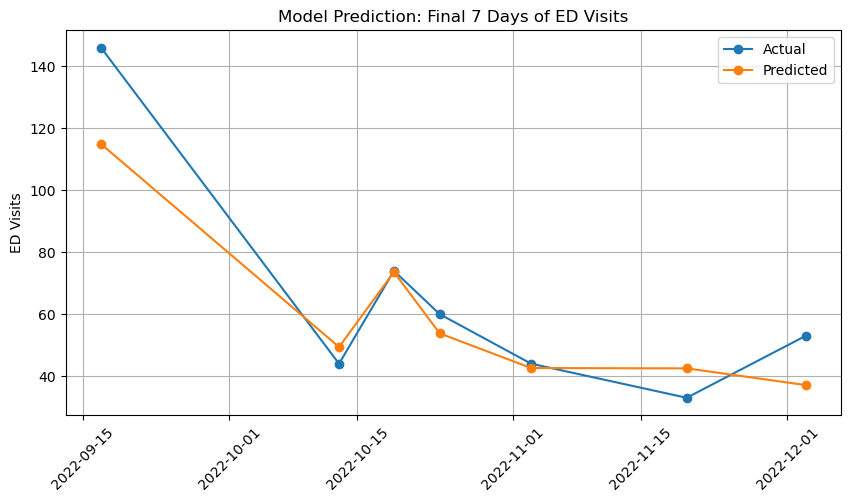

In [78]:
# Create data frame from last 7 rows of the dataset
future_test = df_model.tail(7).copy()       

# Get matching dates from the main data set
last_dates = df_clean["date"].tail(7).values

# spit by x and y for linear regression
X_future = future_test.drop(columns=["total_ed_visits"])
y_future_actual = future_test["total_ed_visits"]

# predict!
y_future_pred = linreg.predict(X_future)

# Create the output table
pred_df = pd.DataFrame({
    "date": last_dates,
    "actual_ED_visits": y_future_actual.values,
    "predicted_ED_visits": y_future_pred.round(1)
})

print(pred_df)

# print
plt.figure(figsize=(10,5))
plt.plot(pred_df["date"], pred_df["actual_ED_visits"], label="Actual", marker="o")
plt.plot(pred_df["date"], pred_df["predicted_ED_visits"], label="Predicted", marker="o")
plt.xticks(rotation=45)
plt.ylabel("ED Visits")
plt.title("Model Prediction: Final 7 Days of ED Visits")
plt.legend()
plt.grid(True)
plt.show()

